In [1]:
#import necessary libraries

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qutip import wigner, Qobj, displace, basis

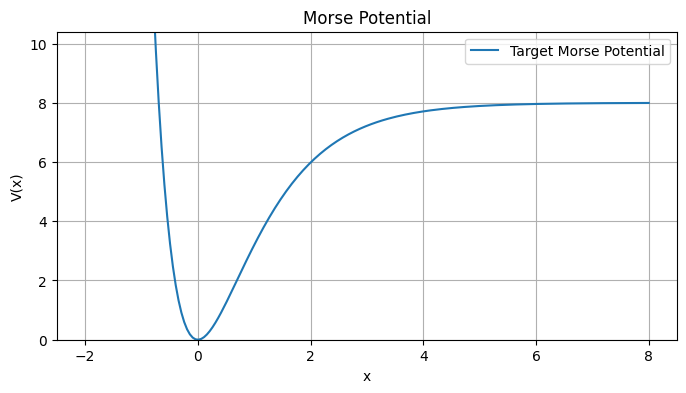

In [77]:
"""
Definining the Operators
- Morse Hamiltonian
- Always-on Hamiltonian
- Displacement Gate
- Qubit xy Rotation Gate
"""

# Time to optimize over
time = 1

# Parameters for Morse Potential
mass = 1
diss_energy = 8
width_param = 1
equib_length = 0

# Oscillator Parameters
omega = 1.0  # Oscillator frequency
chi = 0.01   # Qubit-oscillator coupling

# Other Parameters
hbar = 1 

# Trruncate the Fock Space Based on the number of states supported by the Morse Potential
morse_cap = (int) (np.sqrt(2 * mass * diss_energy) / (width_param * hbar) - (1/2))
N = morse_cap

I_q = np.eye(2) #Identity operator for qubits
I_o = np.eye(N) #Identity operator for qumodes

a = np.diag(np.sqrt(np.arange(1, N)), 1)  # Annihilation operator
adag = a.T.conj()                         # Creation operator
n_op = adag @ a                           # Photon number operator

# Pauli Matrices for qubit
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

H_always_on = (chi * sigma_z + omega * np.eye(2))  # Always-on Hamiltonian for a cavity-QED System
H_always_on = np.kron(H_always_on, n_op)           # Full Always-on Hamiltonian (Qubit-Qumode Hilbert Space)

# Always-on Time Evolution
def H_On_Evo(t):
    return sp.linalg.expm(-1j * H_always_on * t)

# Dispacement Gate 
def displacement(alpha):
    A = alpha * adag - np.conj(alpha) * a
    return sp.linalg.expm(A)

# Dispacement Gate (Qubit-Qumode Hilbert Space)
def D_full(alpha):
    return np.kron(I_q, displacement(alpha))

# Qubit XY Rotation Gate
def R_phi(theta, phi):
    op = (np.cos(phi) * sigma_x + np.sin(phi) * sigma_y)
    return sp.linalg.expm(-1j * theta / 2 * op)

# Qubit XY Rotation Gate (Qubit-Qumode Hilbert Space)
def R_full(theta, phi):
    return np.kron(R_phi(theta, phi), I_o)


# Morse Hamiltonian (Returns the Matrix from the Qubit-Qumode Hilbert Space)
def H_Morse(u ,de, b, x0):
    """
    Morse Hamiltonian Gate

    Args:
        u (real): reduced mass of diatomic system
        de (real): dissociation energy
        b (real): width parameter
        x0 (real): equilibrium bond length

    Returns:
        csc_matrix: operator matrix
    """
    m_omega = np.sqrt(2 * de * (b ** 2) / u)
    X_op = (a + adag) / np.sqrt(2)
    P_op = 1j * (a - adag) / (np.sqrt(2))
    x_op = X_op * np.sqrt(hbar / (u * m_omega))
    p_op = P_op * np.sqrt(hbar * u * omega)

    kin_op = (p_op @ p_op) / (2 * u)

    exp_term = sp.linalg.expm(-1 * b * (x_op - x0 * np.eye(N)))
    mp_op = de * ((np.eye(N) - exp_term) @ (np.eye(N) - exp_term))

    full_m = kin_op + mp_op

    full_m = np.kron(I_q, full_m)

    return full_m

# Time Evolution for the Morse Hamiltonian
def MH_Evo(t, u, de, b, x0):
    return sp.linalg.expm(-1j * H_Morse(u, de, b, x0) * t)

# Build the Gate Sequence (Always-On Time Evolution, Displacement Gate, XY Rotation Gate)
def gate_seq(params, d):
    """
    Builds the Gate Sequence

    Params: Each layer is a list of 4 parameters
    1. alpha_real - real part of alpha which shifts position
    2. alpha_imag - imaginary part of alpha which shifts momentum
    3. theta - one of the parameters for the xy qubit rotation gate
    4. phi - one of the parameters for the xy qubit rotaation gate
    
    """
    U = np.eye(2 * N, dtype=complex)
    for j in range(d):
        alpha_real = params[4*j]
        alpha_imag = params[4*j+1]
        theta = params[4*j+2]
        phi = params[4*j+3]
        
        D = D_full(alpha_real + 1j * alpha_imag)
        R = R_full(theta, phi)
        V = H_On_Evo(time)

        U = U @ V @ R @ D
    return U

# Definition of the cost (infidelity) function
def fidelity_loss(params, d, U_target):
    U = gate_seq(params, d)
    dim = U.shape[0]
    fid = np.abs(np.trace(U.conj().T @ U_target))/ (dim)
    return 1 - fid

# Create an Instance of the Target Morse Hamiltonian Time Evolution
morse_to_optimize = MH_Evo(t=time, u=mass, de=diss_energy, b=width_param, x0=equib_length)

#Plot the Morse Potential

# Position axis
x = np.linspace(-2, 8, 200)

# Morse potential
V_Target = diss_energy * (1 - np.exp(-width_param * (x - equib_length)))**2

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, V_Target, label='Target Morse Potential')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.ylim(0, diss_energy * 1.3)  # Adjust the 1.2 factor as needed
plt.title('Morse Potential')
plt.grid(True)
plt.legend()
plt.show()

In [78]:
# Optimize

d = 8                   # number of gate layers
num_params = d * 4      # [Re(α), Im(α), θ, φ] per gate

# Provides small initial guess near 0
init_guess = np.random.rand(num_params) * 0.1   

# Optimization Function
result = sp.optimize.minimize(
    fidelity_loss,          
    init_guess,
    args=(d, morse_to_optimize),
    method='BFGS',
    options={'disp': True}
)

# Saved values of the optimized parameters
optimal_params = result.x

# Function to Print the Optimized Parameters
def print_optimal_params(params, d):
    print(f"Fock Space Truncation         = {N}")
    print()
    print("Oscillator Paremeters:")
    print(f"    oscillator frequency      = {omega}")
    print(f"    qubit-oscillator coupling = {chi}")
    print()
    print("Morse Parameters Used:")
    print(f"    hbar           = {hbar}")
    print(f"    time           = {time}")
    print(f"    mass           = {mass}")
    print(f"    diss_energy    = {diss_energy}")
    print(f"    width_param    = {width_param}")
    print(f"    equilib_length = {equib_length}")

    print()
    print("-" * 30)

    print("Optimized Paramters")
    for i in range(d):
        re_alpha = params[i * 4 + 0]
        im_alpha = params[i * 4 + 1]
        theta    = params[i * 4 + 2]
        phi      = params[i * 4 + 3]
        
        print(f"Gate {i+1}:")
        print(f"  α     = {re_alpha:.4f} + {im_alpha:.4f}j")
        print(f"  θ     = {theta:.4f}")
        print(f"  φ     = {phi:.4f}")
        print("-" * 30)

# Print the Optimal Parameters
print_optimal_params(optimal_params, d)

Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 807
         Function evaluations: 28809
         Gradient evaluations: 873
Fock Space Truncation         = 3

Oscillator Paremeters:
    oscillator frequency      = 1.0
    qubit-oscillator coupling = 0.01

Morse Parameters Used:
    hbar           = 1
    time           = 1
    mass           = 1
    diss_energy    = 8
    width_param    = 1
    equilib_length = 0

------------------------------
Optimized Paramters
Gate 1:
  α     = -0.0518 + -1.1489j
  θ     = 0.7825
  φ     = 0.1354
------------------------------
Gate 2:
  α     = -0.8293 + 1.9295j
  θ     = 0.3873
  φ     = -0.2273
------------------------------
Gate 3:
  α     = -0.6270 + 1.6156j
  θ     = 2.2646
  φ     = -0.1000
------------------------------
Gate 4:
  α     = -0.9473 + 1.5419j
  θ     = 0.0830
  φ     = 0.1144
------------------------------
Gate 5:
  α     = 1.0015 + -0.8803j
  θ     = -2.6275
  φ     = -0.0964

In [79]:
# Print the Exact Infidelity
infid = fidelity_loss(optimal_params, d, morse_to_optimize)
print(infid)

2.1453698730966586e-05


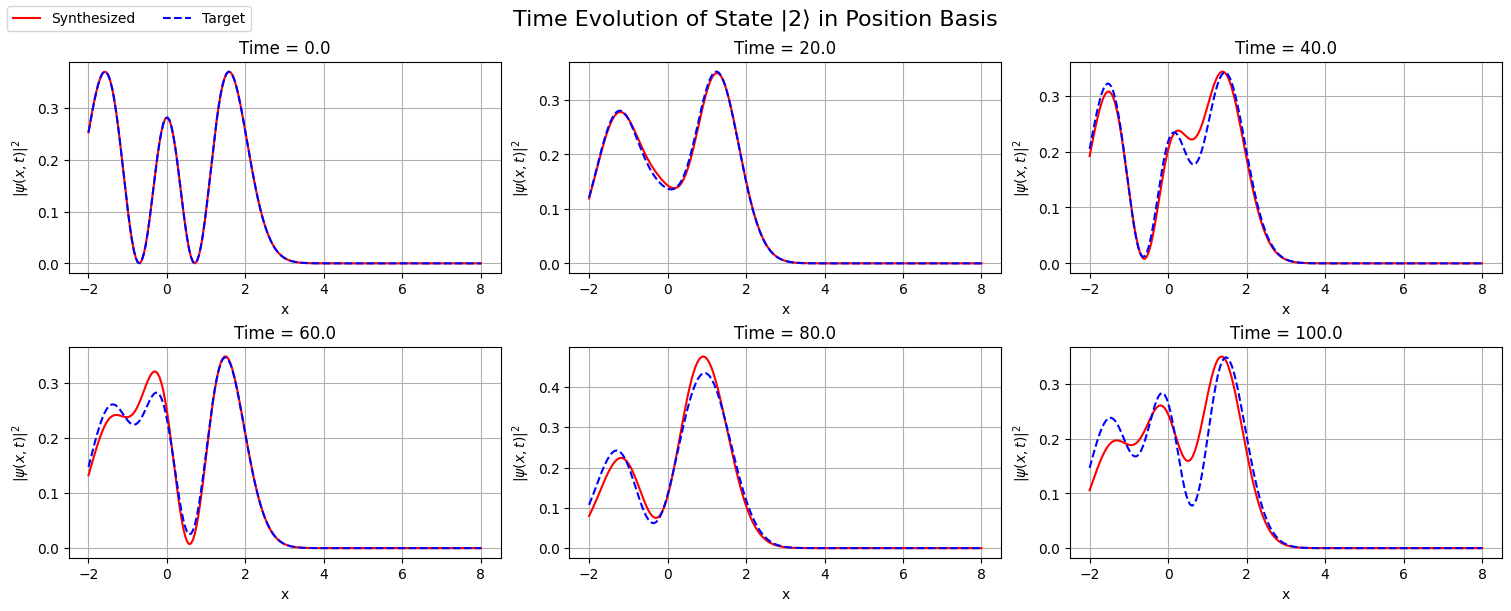

In [93]:
#Build the Synthesized Unitary
morse_generated = gate_seq(optimal_params, d)

# Function to Extract the Qumode Information from the Joint Qubit-Qumode State
def extract_qumode_info(hybrid_state, qubit_state_index, qumode_dim):
    """
    Args:
        hybrid_state: full state vector of shape (2 * qumode_dim,)
        qubit_state_index: 0 or 1
        qumode_dim: dimension of the qumode Fock space

    Returns:
        qumode_state: complex ndarray of shape (qumode_dim,)
    """
    assert hybrid_state.shape[0] == 2 * qumode_dim
    start = qubit_state_index * qumode_dim
    end = start + qumode_dim
    return hybrid_state[start:end]

# Function to Project to the Position Basis
def fock_basis_to_position(x, N, m=mass, hbar=hbar, omega=omega):
    """
    Returns T[i, n] = ⟨x_i | n⟩, i.e., harmonic oscillator wavefunction for n-th Fock state at position x_i
    """
    xi = np.sqrt(m * omega / hbar) * x
    prefactor = (m * omega / (np.pi * hbar))**0.25
    T = np.zeros((len(x), N), dtype=complex)

    for n in range(N):
        norm = 1 / np.sqrt(2**n * sp.special.factorial(n))
        Hn = sp.special.eval_hermite(n, xi)
        psi_n = prefactor * norm * np.exp(-0.5 * xi**2) * Hn
        T[:, n] = psi_n

    return T

# Extract the Hamiltonian from the Time Evolution
tgt_hamiltonian = (1j / time) * sp.linalg.logm(morse_to_optimize)
gen_hamiltonian = (1j / time) * sp.linalg.logm(morse_generated)

# End Time to be Visualized for the Wavefunctions
target_time = 100

# Parameters
x_var = np.linspace(-2, 8, 200)
topos = fock_basis_to_position(x_var, N)

# --- Choose Initial State ---

# Choose the Initial State for the Qubit
init_qubit_state = np.array([1, 0], dtype=complex)

# Choose the Initial State for the Qumode
    # Option 1: Fock state
fock_state_index = 2
init_qumode_state = np.zeros(N, dtype=complex)
init_qumode_state[fock_state_index] = 1.0

    # Option 2: Coherent state
# from qutip import coherent
# alpha = 1.0 + 0.5j
# init_qumode_state = coherent(N, alpha).full().flatten()

# Create the Initial State in the Full Qubit-Qumode Hilbert Space
init_state = np.kron(init_qubit_state, init_qumode_state)

# --- Time Steps ---
n_steps = 6
times = np.linspace(0, target_time, n_steps)

# --- Setup plot grid ---
cols = 3
rows = (n_steps + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), constrained_layout=True)
axes = axes.flatten()

# --- Loop through time evolution ---
for i, t in enumerate(times):
    ax = axes[i]

    # Evolve under synthesized
    U_gen_t = sp.linalg.expm(-1j * gen_hamiltonian * t)
    psi_gen_t = U_gen_t @ init_state
    psi_gen = extract_qumode_info(psi_gen_t, 0, N)
    psi_gen_x = topos @ psi_gen

    # Evolve under true
    U_tgt_t = sp.linalg.expm(-1j * tgt_hamiltonian * t)
    psi_tgt_t = U_tgt_t @ init_state
    psi_tgt = extract_qumode_info(psi_tgt_t, 0, N)
    psi_tgt_x = topos @ psi_tgt

    # Plot
    ax.plot(x_var, np.abs(psi_gen_x)**2, label='Synthesized', color='red')
    ax.plot(x_var, np.abs(psi_tgt_x)**2, label='Target', color='blue', linestyle='--')
    ax.set_title(f'Time = {round(t, 2)}')
    ax.set_xlabel('x')
    ax.set_ylabel(r'$|\psi(x,t)|^2$')
    ax.grid(True)

# Remove unused axes
for j in range(len(times), len(axes)):
    fig.delaxes(axes[j])

# Shared legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize='medium')
plt.suptitle(f'Time Evolution of State |{fock_state_index}⟩ in Position Basis', fontsize=16)
plt.show()


Fidelity at t = 0.00: 1.000000
Fidelity at t = 200.00: 0.934417
Fidelity at t = 400.00: 0.787895
Fidelity at t = 600.00: 0.661898
Fidelity at t = 800.00: 0.647811
Fidelity at t = 1000.00: 0.754715


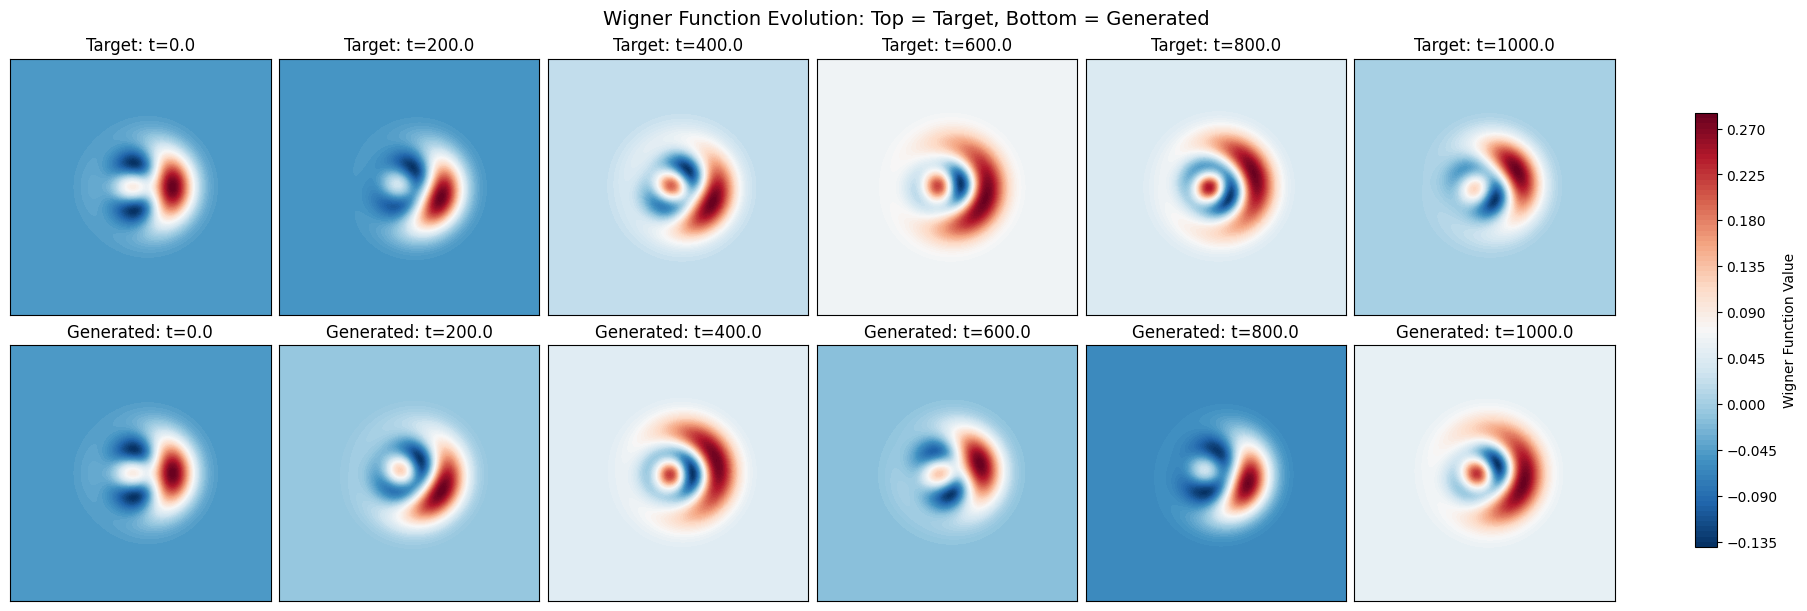

In [95]:
# Visualization for the Evolution of the Wigner Function Over Time

# Extract the Hamiltonian from the Time Evolution
target_hamiltonian = (1j / time) * sp.linalg.logm(morse_to_optimize)
generated_hamiltonian = (1j / time) * sp.linalg.logm(morse_generated)

# Choose the Number of Steps and Final Time to Visualize
steps = 5
time_and_extra = time + 999
time_step = time_and_extra / steps

# Define phase space grid
xvec = np.linspace(-5, 5, 200)

# --- Choose Initial State ---

# Choose the Initial State for the Qubit
wig_init_qubit_state = np.array([1, 0], dtype=complex)

# Choose the Initial State for the Qumode
    # Option 1: Fock state
# wig_fock_state_index = 2
# wig_init_qumode_state = np.zeros(N, dtype=complex)
# wig_init_qumode_state[fock_state_index] = 1.0

    # Option 2: Coherent state
from qutip import coherent
coherent_alpha = 1.0
wig_init_qumode_state = coherent(N, coherent_alpha).full().flatten()

# Create the Initial State in the Full Qubit-Qumode Hilbert Space
init_matrix = np.kron(wig_init_qubit_state, wig_init_qumode_state)

fig, axes = plt.subplots(2, steps+1, figsize=(3 * (steps+1), 6), constrained_layout=True)
fig.suptitle('Wigner Function Evolution: Top = Target, Bottom = Generated', fontsize=14)

for i in range(steps+1):
    t = i * time_step
    U_gen_t_wig = sp.linalg.expm(-1j * generated_hamiltonian * t)
    U_tgt_t_wig = sp.linalg.expm(-1j * target_hamiltonian * t)

    step_state_generated = U_gen_t_wig @ init_matrix
    step_state_target = U_tgt_t_wig @ init_matrix

    # Calculate Fidelity at Each Step
    fidelity = np.abs(np.vdot(step_state_generated, step_state_target))**2
    print(f"Fidelity at t = {t:.2f}: {fidelity:.6f}")

    qumode_generated = extract_qumode_info(step_state_generated, qubit_state_index=0, qumode_dim=N)
    qumode_target = extract_qumode_info(step_state_target, qubit_state_index=0, qumode_dim=N)

    # Convert to Qobj
    step_qobj_generated = Qobj(qumode_generated, dims=[N, [1]])
    step_qobj_target = Qobj(qumode_target, dims=[N, [1]])

    # Compute Wigner functions
    W_gen = wigner(step_qobj_generated, xvec, xvec)
    W_tar = wigner(step_qobj_target, xvec, xvec)

    # Top row: target
    ax_tar = axes[0, i]
    im1 = ax_tar.contourf(xvec, xvec, W_tar, 100, cmap='RdBu_r')
    ax_tar.set_title(f'Target: t={round(i*time_step, 2)}')
    ax_tar.set_xticks([])
    ax_tar.set_yticks([])

    # Bottom row: generated
    ax_gen = axes[1, i]
    im2 = ax_gen.contourf(xvec, xvec, W_gen, 100, cmap='RdBu_r')
    ax_gen.set_title(f'Generated: t={round(i*time_step, 2)}')
    ax_gen.set_xticks([])
    ax_gen.set_yticks([])

# Add single shared colorbar using a separate figure method
fig.colorbar(im1, ax=axes, location='right', shrink=0.8, label='Wigner Function Value')

plt.show()

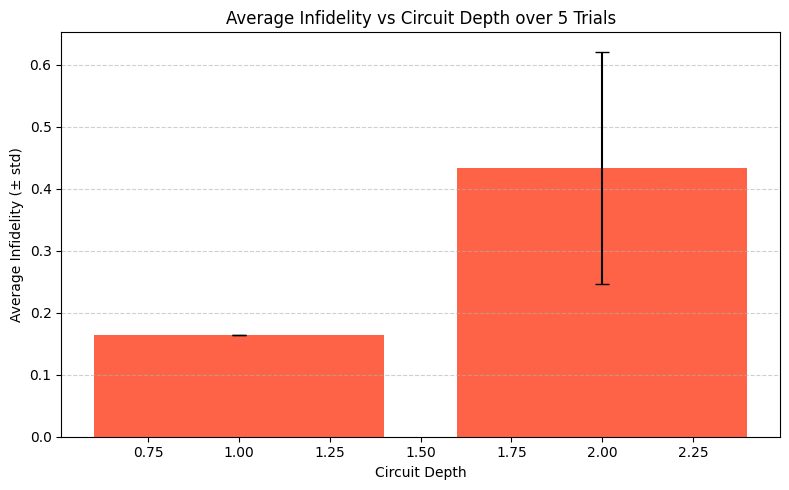

Depth 1: mean = 0.164113, std = 0.000000
Depth 2: mean = 0.433962, std = 0.187323


In [69]:
# Infidelity vs Gate Depth

min_depth = 1
max_depth = 2
depths = [x for x in range(min_depth, max_depth + 1)]
infidelities_mean = []
infidelities_std = []

n_trials = 5  # Number of optimization runs per depth

for depth in depths:
    num_params = depth * 4
    trial_infid = []

    for trial in range(n_trials):
        init_guess = np.random.rand(num_params) * 0.1

        result = sp.optimize.minimize(
            fidelity_loss,
            init_guess,
            args=(depth, morse_to_optimize),
            method='BFGS',
            options={'disp': False}
        )

        params_optimized = result.x
        infid = fidelity_loss(params_optimized, depth, morse_to_optimize)
        trial_infid.append(infid)

    # Record average and std dev
    infidelities_mean.append(np.mean(trial_infid))
    infidelities_std.append(np.std(trial_infid))

# --- Plot with error bars ---
plt.figure(figsize=(8, 5))
plt.bar(depths, infidelities_mean, yerr=infidelities_std, capsize=5, color='tomato')
plt.xlabel('Circuit Depth')
plt.ylabel('Average Infidelity (± std)')
plt.title(f'Average Infidelity vs Circuit Depth over {n_trials} Trials')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: print full data
for d, mean, std in zip(depths, infidelities_mean, infidelities_std):
    print(f"Depth {d}: mean = {mean:.6f}, std = {std:.6f}")